In [1]:
import os 
import pandas as pd
import matplotlib.pyplot as plt

datapath = 'universe_8/' # all of the data is within a folder in this .ipynb file's directory
GalaxyNames = []




for clusterFile in os.listdir(datapath + '\Star Clusters'):
    GalaxyNames.append(clusterFile[:-4]) 
    

In [7]:
import numpy as np
import pandas as pd

def importGalaxy(name):
    # read the data from the .txt file into a dataframe
    galaxdata = pd.read_csv(datapath + f'/Star Clusters/{name}.csv', delimiter=' ')
    galaxEquat, galaxPolar = np.mean(galaxdata['X']), np.mean(galaxdata['Y']) # get the approx. center coords
    galaxVel = np.mean(galaxdata['RadialVelocity']) # get the approx. radial velocity of the galaxy as a whole
    # now subtract the mean velocity from each, and take the absolute value so we have a velocity magnitude
    orbitVels = abs(galaxdata['RadialVelocity'] - galaxVel).to_numpy()  
    # now to get the apparent radius of each star from the galactic center. We do this via the formula
    # r = sqrt([x - x_mean]^2 + [y - y_mean]^2)     for each star
    sqEquats = (galaxdata['X'] - galaxEquat)**2 
    sqPolars = (galaxdata['Y'] - galaxPolar)**2 
    orbitRadii = np.sqrt(sqEquats + sqPolars).to_numpy()
    orbitRadii = orbitRadii / max(orbitRadii) # get the orbit radii relative to the galaxy radius
    return orbitRadii, orbitVels

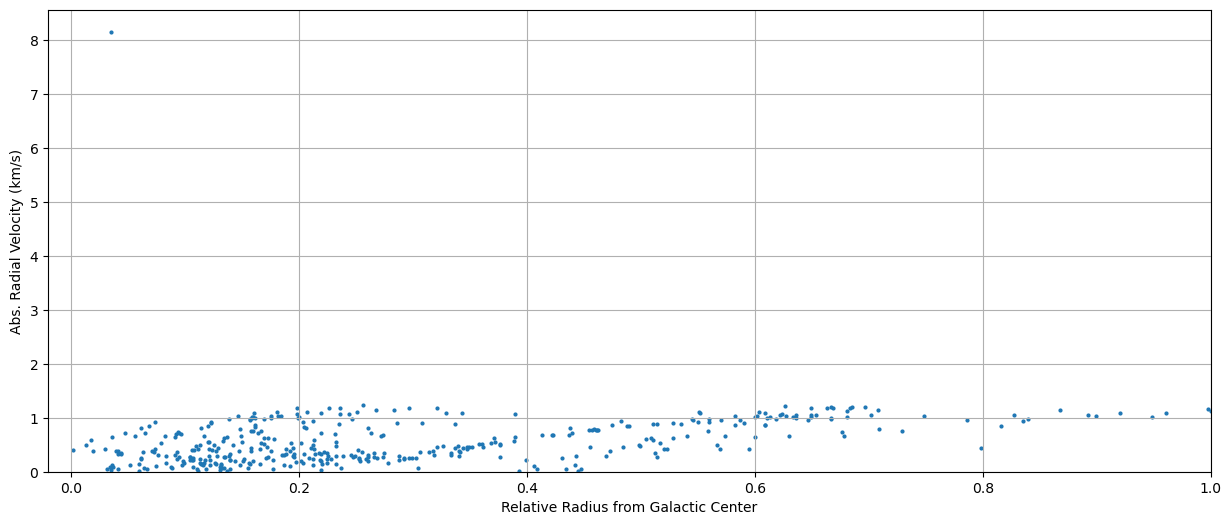

In [8]:
import matplotlib.pyplot as plt

orbitRadii, orbitVels = importGalaxy(GalaxyNames[0]) 

fig, ax = plt.subplots(figsize=(15, 6))
ax.scatter(orbitRadii, orbitVels, s=4)
ax.set_xlabel("Relative Radius from Galactic Center")
ax.set_ylabel("Abs. Radial Velocity (km/s)")
ax.set_ylim(ymin=0); ax.set_xlim(-0.02, 1)
ax.grid()

In [44]:
def curveCeiling(radii, velocities):
    nSegments = 40 
    ceilingRad, ceilingVels = np.zeros(nSegments), np.zeros(nSegments)
    for i in range(nSegments): 
        center = i * 1 / nSegments 
        dr = 1/2 * 1/nSegments 
        indices = np.argwhere(np.logical_and(center - dr <= radii, radii <= center + dr))
        rads = radii[indices] # get the orbital radii of these indices
        vels = velocities[indices] # as above, with velocities
        if len(rads) < 1: 
            pass
        else: 
            maxIndex = np.argmax(vels)
            ceilingRad[i] = rads[maxIndex]
            ceilingVels[i] = vels[maxIndex]
    
    ceilingRad = ceilingRad[np.nonzero(ceilingVels)] 
    ceilingVels = ceilingVels[np.nonzero(ceilingVels)]
    
    return ceilingRad, ceilingVels

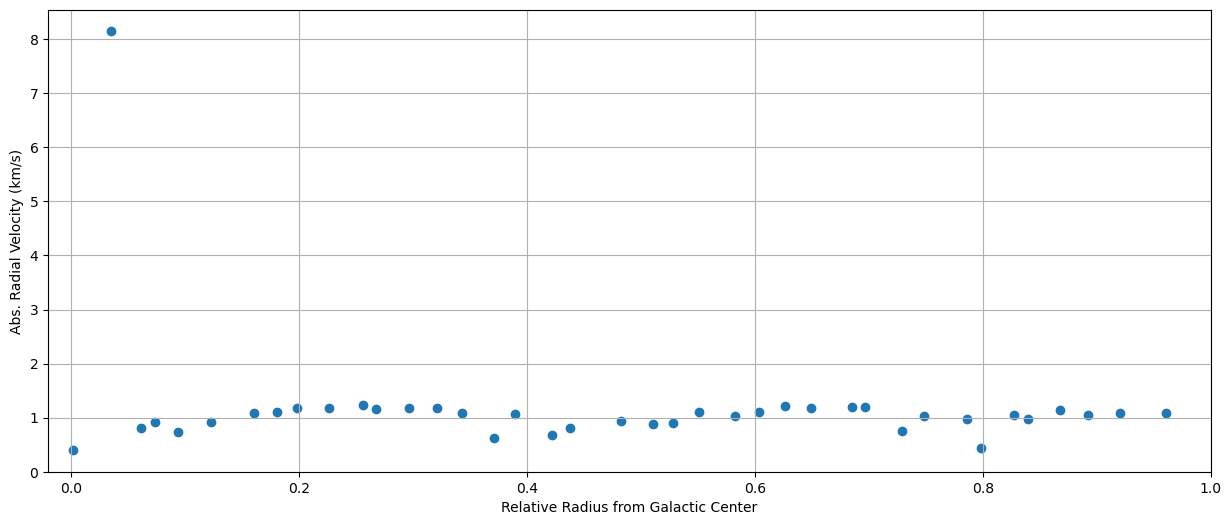

In [11]:
sortRad, sortVels = curveCeiling(orbitRadii, orbitVels)

fig, ax = plt.subplots(figsize=(15, 6))
ax.scatter(sortRad, sortVels)
ax.set_xlabel("Relative Radius from Galactic Center")
ax.set_ylabel("Abs. Radial Velocity (km/s)")
ax.set_ylim(ymin=0); ax.set_xlim(-0.02, 1)
ax.grid()

In [12]:
def BHDMCurve(r, a, b, c):
    return a * r**-2 + b * np.sqrt(r) + c * r

a=6.697467727367837e-07, b=4.767, c=-4.233


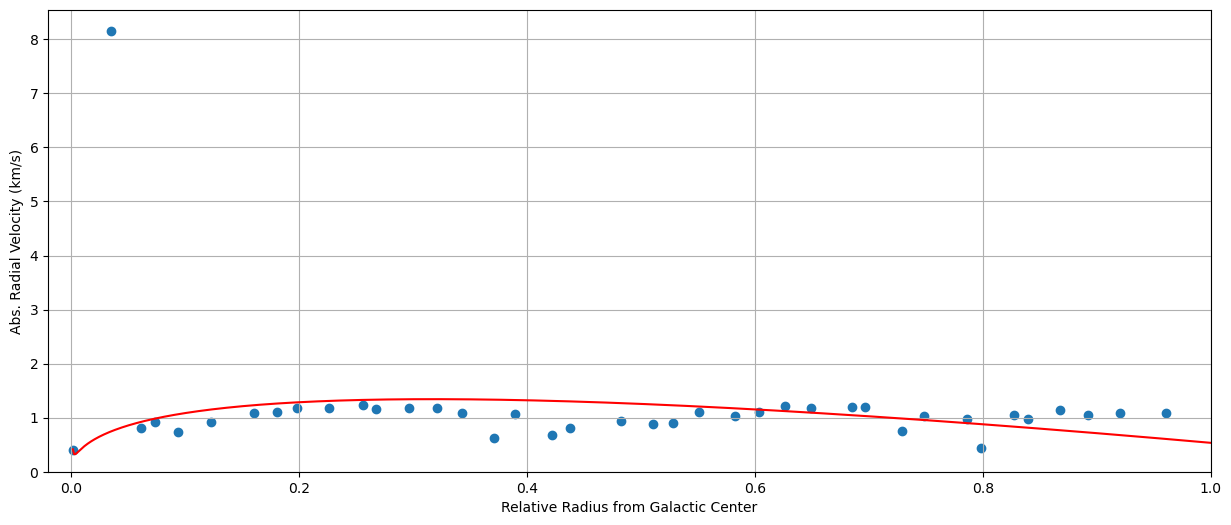

In [13]:
from scipy.optimize import curve_fit
coefficients, params = curve_fit(BHDMCurve, sortRad, sortVels, p0=[0.01, 2, -1])
a, b, c = coefficients
print(f"{a=}, {b=:.3f}, {c=:.3f}")
X = np.linspace(min(sortRad), 1, 1000)
fig, ax = plt.subplots(figsize=(15, 6))
ax.scatter(sortRad, sortVels)
ax.plot(X, BHDMCurve(X, a, b, c), c='r')
ax.grid()
ax.set_xlabel("Relative Radius from Galactic Center")
ax.set_ylabel("Abs. Radial Velocity (km/s)")
ax.set_ylim(ymin=0); ax.set_xlim(-0.02, 1);

(-0.02, 1.0)

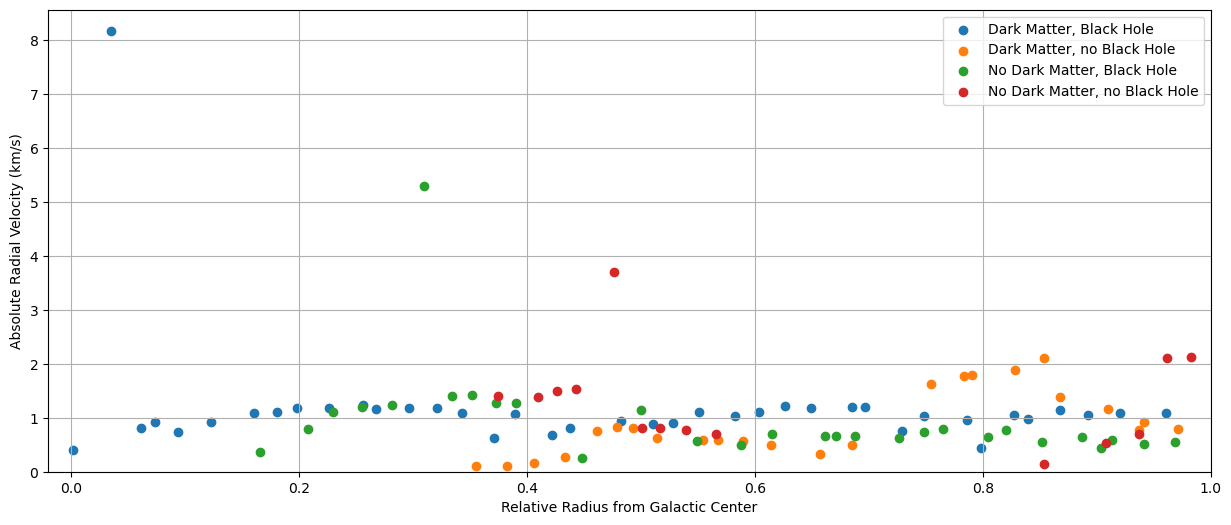

In [42]:
fig, ax = plt.subplots(figsize=(15, 6))
# I've hand picked some galaxies here, to show the different rotation curve types.
labels = ["Dark Matter, Black Hole", 'Dark Matter, no Black Hole', 'No Dark Matter, Black Hole', 'No Dark Matter, no Black Hole'] 
for i, num in enumerate([3, 2, 9, 12]): 
    name = GalaxyNames[num] # find the galaxy name
    orbitRadii, orbitVels = importGalaxy(name) # import data
    sortRad, sortVels = curveCeiling(orbitRadii, orbitVels) # find data ceiling
    ax.scatter(sortRad, sortVels, label = labels[i]) # and plot with the label

ax.grid(); ax.legend(loc='upper right')
ax.set_xlabel("Relative Radius from Galactic Center")
ax.set_ylabel("Absolute Radial Velocity (km/s)")
ax.set_ylim(ymin=0); ax.set_xlim(-0.02, 1)

In [16]:
def DMCurve(r, a, b, c):
    return a * (r)**b + c * r

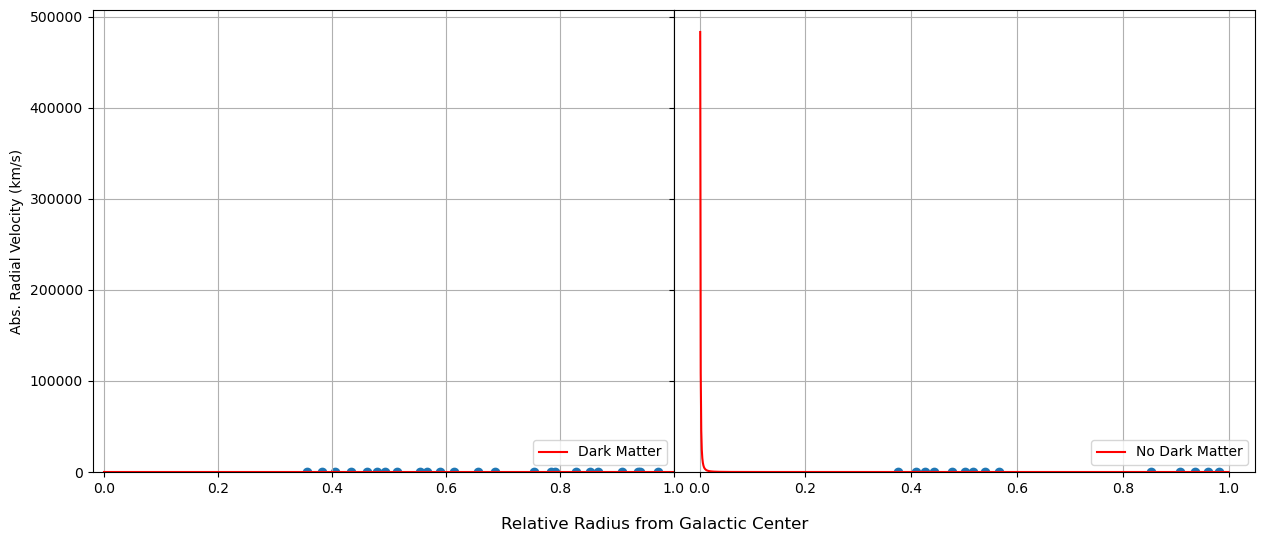

In [36]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6), sharey=True)
fig.subplots_adjust(wspace=0)
X = np.linspace(0, 1, 1000)
labels = ["Dark Matter", "No Dark Matter"]
for i, name in enumerate([GalaxyNames[2], GalaxyNames[12]]):
    orbitRadii, orbitVels = importGalaxy(name) # import data
    sortRad, sortVels = curveCeiling(orbitRadii, orbitVels)
    coefficients, params = curve_fit(DMCurve, sortRad, sortVels, p0=[0.01, 0.5, 1])
    a, b, c = coefficients
    ax[i].scatter(sortRad, sortVels)
    ax[i].plot(X, DMCurve(X, a, b, c), c='r', label=labels[i])
    ax[i].grid(); ax[i].legend(loc='lower right')
    
ax[0].set_xlim(-0.02, 1)
ax[0].set_ylabel("Abs. Radial Velocity (km/s)")
ax[0].set_ylim(ymin=0)
fig.supxlabel("Relative Radius from Galactic Center");

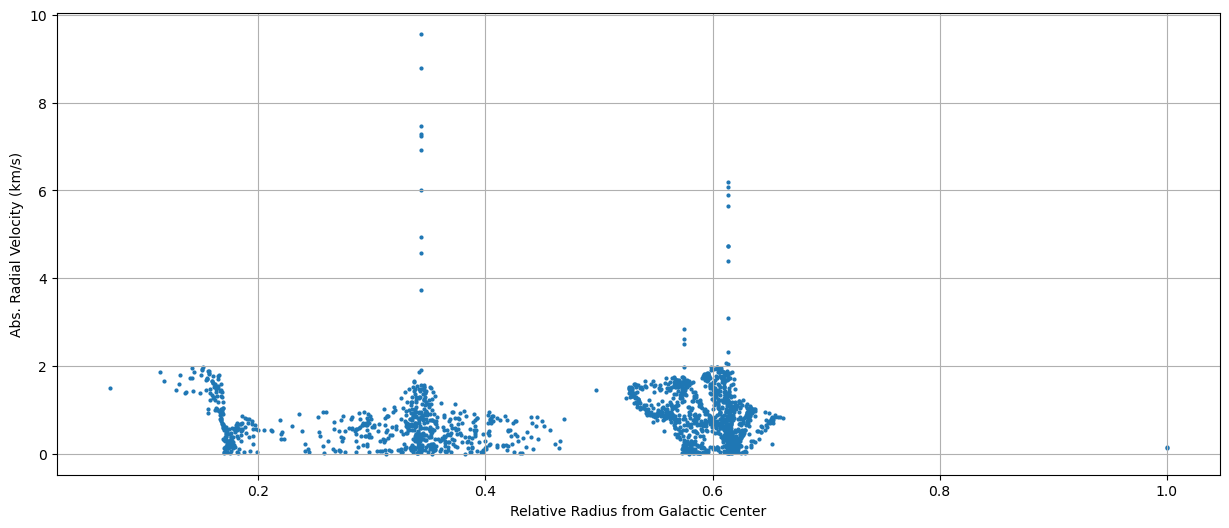

In [41]:
orbitRadii, orbitVels = importGalaxy(GalaxyNames[1]) # this galaxy in particular has a NOT nice curve

fig, ax = plt.subplots(figsize=(15, 6))
ax.scatter(orbitRadii, orbitVels, s=4)
ax.set_xlabel("Relative Radius from Galactic Center")
ax.set_ylabel("Abs. Radial Velocity (km/s)")

ax.grid()

TypeError: Improper input: func input vector length N=3 must not exceed func output vector length M=1

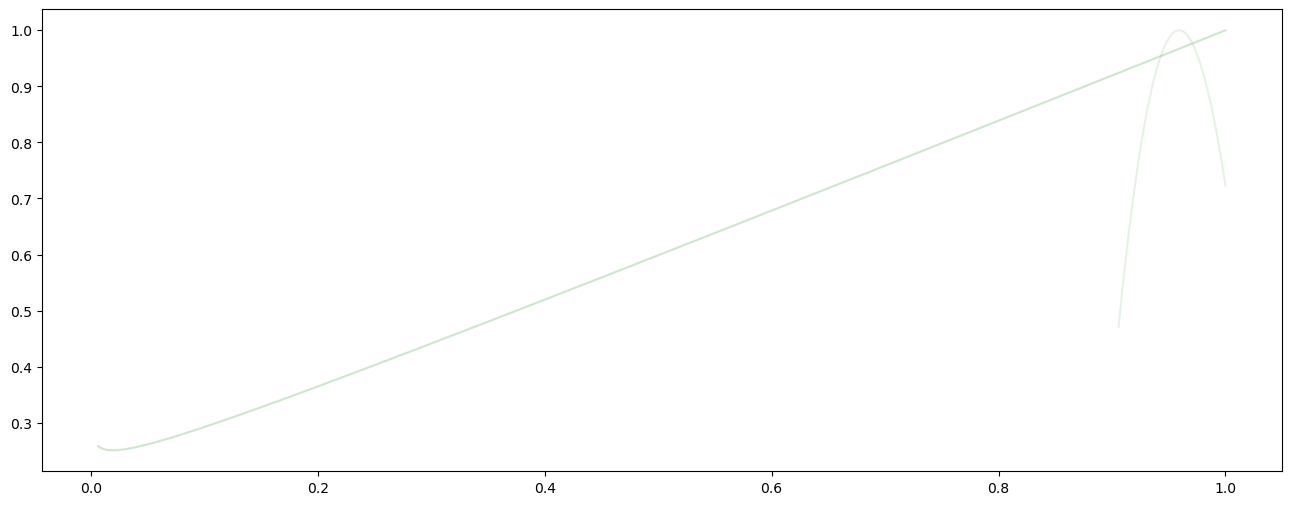

In [40]:
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings('ignore')  # this code is going to give some RuntimeWarnings that I don't care about!

fig, ax = plt.subplots(figsize=(16, 6))

for i, name in enumerate(GalaxyNames):
    # a lot of the curves won't fit, which will generate an error. Hence, i need a try/except block to avoid
    # the program dying before we can fit 
    try:
        orbitRadii, orbitVels = importGalaxy(name)
        sortRad, sortVels = curveCeiling(orbitRadii, orbitVels)
        
        (DMa, DMb, DMc), params = curve_fit(DMCurve, sortRad, sortVels, p0=[0.01, 0.5, 1])
        yDM = DMCurve(sortRad, DMa, DMb, DMc)
        r2DM = r2_score(sortVels, yDM)
        
        (BHa, BHb, BHc), params = curve_fit(BHDMCurve, sortRad, sortVels, p0=[0.01, 2, -1])
        yBH = BHDMCurve(sortRad, BHa, BHb, BHc)
        r2BH = r2_score(sortVels, yBH)
        
        if max([r2BH, r2DM]) > 0.8:
            X = np.linspace(min(sortRad), 1, 1000)
            if r2BH > r2DM:
                Y = BHDMCurve(X, BHa, BHb, BHc)
            else:
                Y = DMCurve(X, DMa, DMb, DMc)
            ax.plot(X, Y / max(Y), c='g', alpha=0.1)
    except RuntimeError:
        pass
    
ax.set_xlim(-0.02, 1)
ax.set_ylabel("Relative Radial Velocity (prop of VmaxVmaxV_{max})")
ax.set_ylim(ymin=0, ymax=1.01)

ax.set_xlabel("Relative Radius from Galactic Center");